<a href="https://colab.research.google.com/github/dianatuyen/CS-4710-AI-Fire/blob/main/CS4710Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Finding Satellite Image Dataset (Diana & Tamera)
Websites(Sattelite Datbases):
- https://search.earthdata.nasa.gov/search?q=C2565791013-LPCLOUD # monthly active fires
- https://www.earthdata.nasa.gov/learn/pathfinders/wildfires-data-pathfinder/find-data#pre-fire
- https://www.earthdata.nasa.gov/learn/pathfinders/wildfires-data-pathfinder/find-data#post-fire-impacts
what we are using-
- https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs

Step 2: Label & Preprocess to Train

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/AITrainingUnzip/Training/No_Fire/" | wc -l

ls: cannot access '/content/drive/My Drive/AITrainingUnzip/Training/No_Fire/': No such file or directory
0


In [ ]:
!unzip "/content/drive/My Drive/Training.zip" -d "/content/drive/My Drive/AITrainingUnzip"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1670.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1674.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1675.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1695.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1718.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1734.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1753.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1788.jpg  
  inflating: /content/drive/My Drive/AITrainingUnzip/Training/No_Fire/lake_resized_lake_frame1793.jpg  
  inflating: 

In [ ]:
!ls "/content/drive/My Drive/AITrainingUnzip/Training/No_Fire/" | wc -l

14357


In [ ]:
import os.path

In [ ]:
fire_directory = '/content/drive/My Drive/AITrainingUnzip/Training/Fire/'
nofire_directory = '/content/drive/My Drive/AITrainingUnzip/Training/No_Fire/'

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, DepthwiseConv2D, ReLU, AvgPool2D, GlobalAveragePooling2D

In [ ]:
tf.random.set_seed(27)

In [ ]:
from keras.preprocessing import image
from tqdm import tqdm

batch_size = 32;
img_height = 256;
img_width = 256;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/AITrainingUnzip/Training/',
    validation_split = 0.2,
    subset = "training",
    seed = 27,
    image_size= (img_height, img_width),
    batch_size = batch_size,
    shuffle=True
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/AITrainingUnzip/Training/',
    validation_split = 0.2,
    subset = "validation",
    seed = 27,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle=True
)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

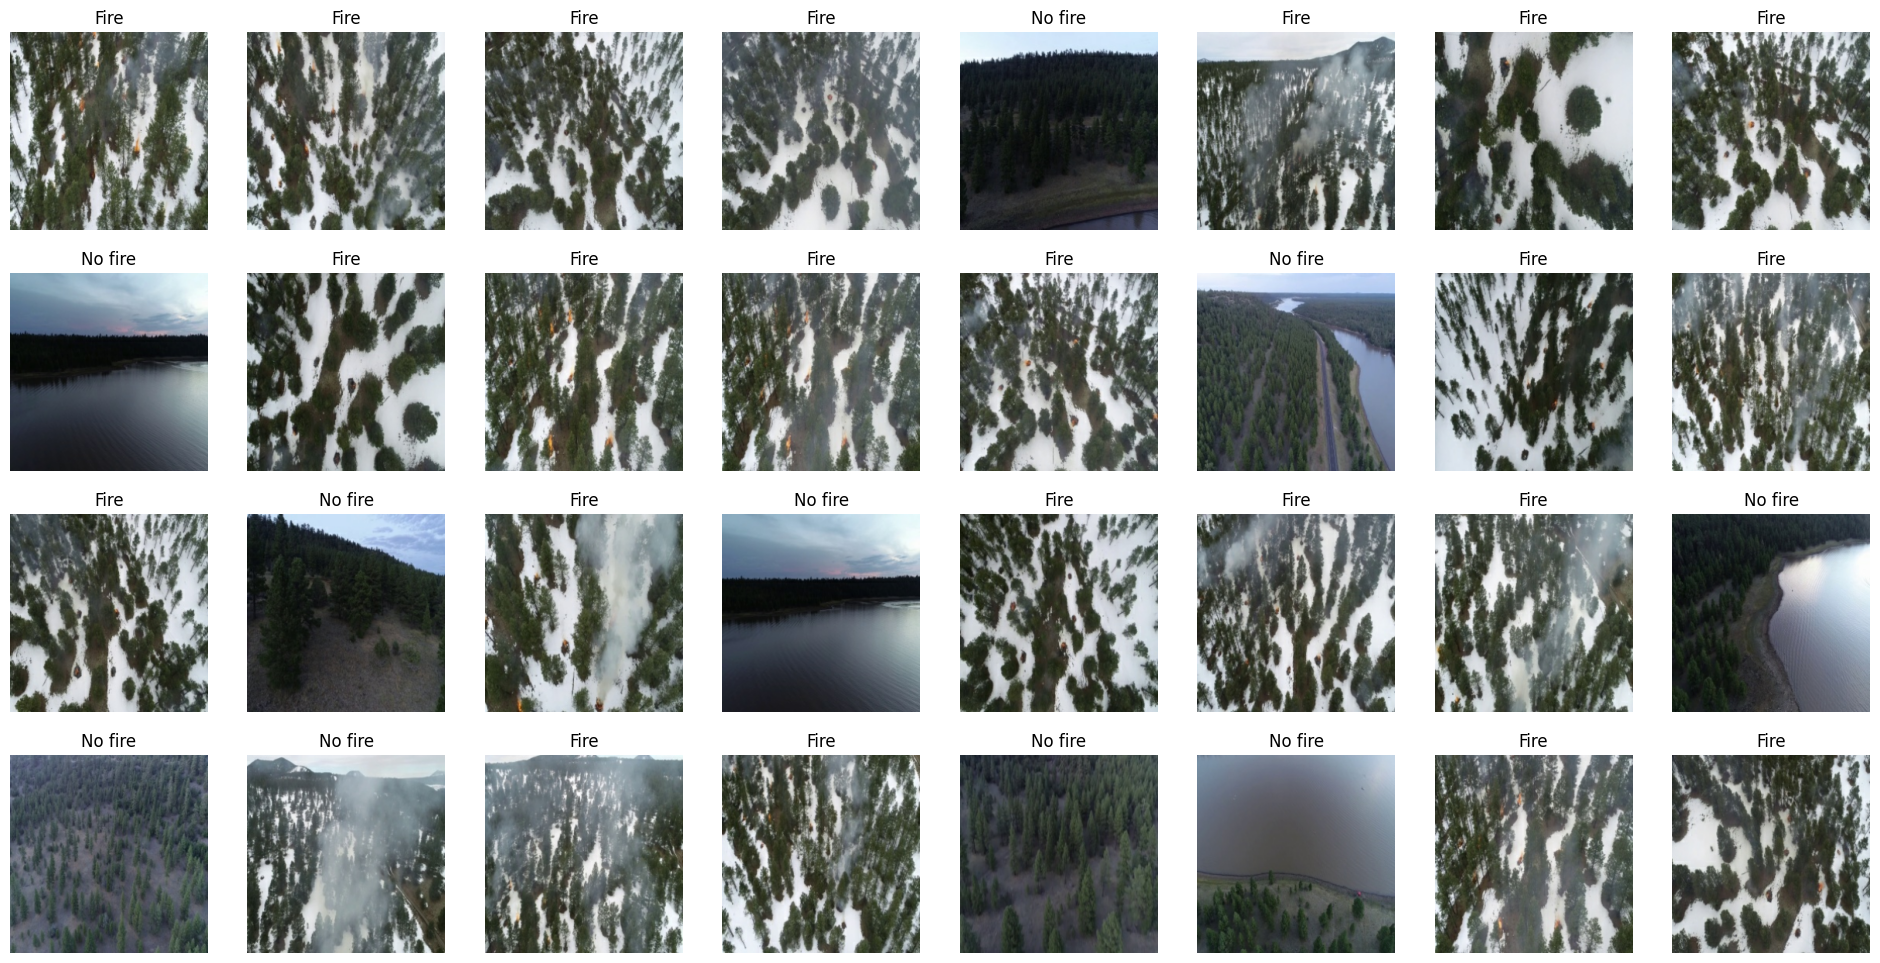

In [ ]:
class_names = ['Fire', 'No fire']

n_rows = 4
n_cols = 8
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]])
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Step 3: Training

In [ ]:
def mobile_net_block(x, filters, strides):
  x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters, kernel_size=1)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x

In [ ]:
def OurModel():
  input = Input(shape=(img_height, img_width, 3))
  x = Sequential([
            keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            keras.layers.experimental.preprocessing.RandomRotation(0.1),
        ])(input)

  x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
  x = Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # MobileNet Architecture
  x = mobile_net_block(x, 64, (1,1))
  x = mobile_net_block(x, 128, (2,2))
  x = mobile_net_block(x, 128, (1,1))
  x = mobile_net_block(x, 256, (2,2))
  x = mobile_net_block(x, 256, (1,1))
  x = mobile_net_block(x, 512, (2,2))

  for _ in range(5):
    x = mobile_net_block(x, 512, (1,1))

  x = mobile_net_block(x, 1024, (2,2))
  x = mobile_net_block(x, 1024, (1,1))

  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.5)(x)
  output = Dense(units=1, activation='sigmoid')(x)

  model = keras.Model(input, output, name="fnf_model")
  return model

In [ ]:
ourModel = OurModel()
ourModel.summary()

Model: "fnf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      864       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                         

In [ ]:
keras.utils.plot_model(ourModel, to_file='fnf_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
def train(model, train_ds, val_ds):
  train_ds = train_ds.prefetch(buffer_size=32)
  val_ds = val_ds.prefetch(buffer_size=32)

  def lr(epoch):
    return 0.001

  epochs = 30
  checkpoints = keras.callbacks.ModelCheckpoint("fnf_model_{epoch}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  learning_rate = keras.callbacks.LearningRateScheduler(lr)
  callbacks = [checkpoints, learning_rate,]
  loss = 'binary_crossentropy'
  metrics = ['accuracy']
  optimizer = keras.optimizers.Adam()

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics,)
  res_fire = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, batch_size=batch_size)

In [ ]:
train(ourModel, train_ds=train_ds, val_ds=validation_ds)

Epoch 1/30
985/985 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9644
Epoch 1: val_accuracy improved from -inf to 0.93105, saving model to fnf_model_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


985/985 [==============================] - 1121s 986ms/step - loss: 0.1018 - accuracy: 0.9644 - val_loss: 0.1623 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 2/30
985/985 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9808
Epoch 2: val_accuracy improved from 0.93105 to 0.96698, saving model to fnf_model_2.h5
985/985 [==============================] - 963s 977ms/step - loss: 0.0533 - accuracy: 0.9808 - val_loss: 0.1121 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 3/30
985/985 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9861
Epoch 3: val_accuracy did not improve from 0.96698
985/985 [==============================] - 949s 963ms/step - loss: 0.0385 - accuracy: 0.9861 - val_loss: 0.2328 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 4/30
985/985 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9890
Epoch 4: val_accuracy improved from 0.96698 to 0.98844, saving model to fnf_model_4.h5
985/985 [==============================] -

KeyboardInterrupt: 

In [ ]:
loadOurModel = keras.models.load_model('/content/fnf_model_6.h5')

In [ ]:
img = keras.preprocessing.image.load_img("/content/drive/My Drive/AITrainingUnzip/Training/Fire/resized_frame1801.jpg", target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = loadOurModel.predict(img_array)
score = predictions[0]
print("This image is %.2f percent Fire and %.2f percent No Fire." % (100 * (1 - score), 100 * score))

1/1 [==============================] - 1s 930ms/step
This image is 99.96 percent Fire and 0.04 percent No Fire.


<ipython-input-24-ed019d4dfd30>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent Fire and %.2f percent No Fire." % (100 * (1 - score), 100 * score))
